In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gc
from tqdm.notebook import tqdm
from collections import deque

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, GPT2LMHeadModel, set_seed

from src.config import Config
from src.dataset import SBICDataset

CONFIG:Config = Config()
set_seed(CONFIG.seed)

2023-09-28 11:40:17.063268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 11:40:17.703396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_pickle(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,offensiveYN,speakerMinorityYN,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
1,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
2,0.0,0.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
3,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2', padding_side="left")
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

tokenizer.add_special_tokens(CONFIG.train_params.special_tokens)
print("List of all special token and its token_id:")
print(" -", tokenizer.all_special_tokens)
print(" -",tokenizer(tokenizer.all_special_tokens)["input_ids"])
print("Model vocab size pre resize:", model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print("Model vocab size post resize:", model.config.vocab_size)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.sep_token_id = tokenizer.sep_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
print("Model pad token:", model.config.pad_token_id)
print("Model sep token:", model.config.sep_token_id)

model.generation_config.max_new_tokens=50

List of all special token and its token_id:
 - ['[STR]', '[END]', '<|endoftext|>', '[SEP]', '[PAD]', '[offY]', '[offN]', '[sexY]', '[sexN]', '[intY]', '[intN]', '[grpY]', '[grpN]', '[ingrpN]', '[ingrpY]']
 - [[50257], [50258], [50256], [50260], [50259], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268], [50269], [50270]]
Model vocab size pre resize: 50257
Model vocab size post resize: 50271
Model pad token: 50259
Model sep token: 50260


In [5]:
train_data = pd.read_pickle(CONFIG.dataset.train_data_raw).to_numpy()[4:5]
# val_data = pd.read_pickle(CONFIG.dataset.val_data_raw).to_numpy()[:100]

train_dataset = SBICDataset(train_data, tokenizer, max_sequence_length=256)
# val_dataset = SBICDataset(val_data, tokenizer, CONFIG.utils.class_label_encoder)

train_loader = DataLoader(train_dataset, batch_size=1, drop_last=False, shuffle=True, pin_memory=True)
# val_loader   = DataLoader(val_dataset,   batch_size=CONFIG.train_params.batch_size, drop_last=False, shuffle=True, pin_memory=True)

In [6]:
# model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(CONFIG.train_params.device)

optimizer = AdamW(model.parameters(), lr=1e-4)

total_loss = 0
loss_epochs = deque(maxlen=200)

for epoch in range(200):
    model.train()
    epoch_train_loss = 0.0
    for n_iter, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # for n_iter, batch in enumerate(tqdm(train_loader, total=len(train_loader))):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        
        model.zero_grad()
            
        # Forward pass
        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        labels = inputs["labels"] )
        loss, logit = outputs[:2]

        total_loss += loss.item()

        if n_iter % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()} iteration n°{n_iter+1}")
        
        # Backward pass
        loss.backward()
        loss_epochs.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
                
        # gc.collect()

    avg_epoch_loss = total_loss / len(train_loader)

gc.collect
torch.cuda.empty_cache()

Epoch 0: loss = 23.670480728149414 iteration n°1
Epoch 1: loss = 12.021056175231934 iteration n°1
Epoch 2: loss = 12.372638702392578 iteration n°1
Epoch 3: loss = 5.281126976013184 iteration n°1
Epoch 4: loss = 10.98064136505127 iteration n°1
Epoch 5: loss = 10.934350967407227 iteration n°1
Epoch 6: loss = 8.62335205078125 iteration n°1
Epoch 7: loss = 5.828688621520996 iteration n°1
Epoch 8: loss = 6.66699743270874 iteration n°1
Epoch 9: loss = 6.764341831207275 iteration n°1
Epoch 10: loss = 5.879530429840088 iteration n°1
Epoch 11: loss = 3.8842146396636963 iteration n°1
Epoch 12: loss = 4.615475654602051 iteration n°1
Epoch 13: loss = 3.4908947944641113 iteration n°1
Epoch 14: loss = 3.213285207748413 iteration n°1
Epoch 15: loss = 3.5041940212249756 iteration n°1
Epoch 16: loss = 3.4629828929901123 iteration n°1
Epoch 17: loss = 3.9380180835723877 iteration n°1
Epoch 18: loss = 3.2892463207244873 iteration n°1
Epoch 19: loss = 3.3407158851623535 iteration n°1
Epoch 20: loss = 3.23

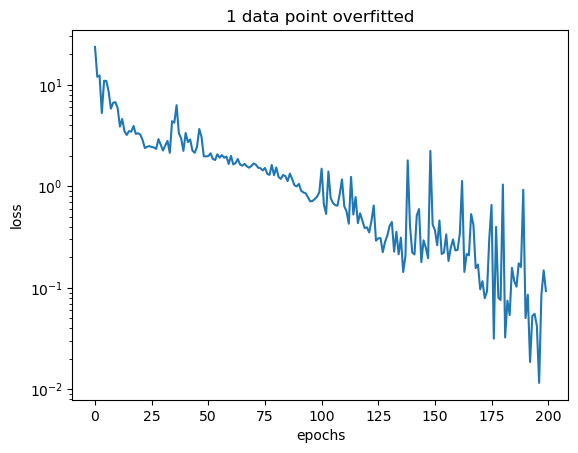

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(loss_epochs)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("1 data point overfitted")
plt.show()

In [12]:
train_data[0][5]

'RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.'

In [39]:
model.eval()

post = train_data[0][5]
inputs_str = tokenizer.bos_token + post + tokenizer.sep_token
next_token = ""
for i in range(15):
    inputs_str += next_token
    inputs = tokenizer(inputs_str, padding="max_length", max_length=256, return_tensors="pt")
    inputs = {k: v.to(CONFIG.train_params.device) for k, v in inputs.items()}

    outputs = model(**inputs)
        
    logits = outputs.logits[0, -1, :]
    next_token = tokenizer.decode(torch.argmax(logits, axis=-1))

    print(inputs_str, "->", next_token, "")

[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP] -> [grpY] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY] -> [SEP] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP] -> [offY] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP][offY] -> [SEP] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP][offY][SEP] -> [offY] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP][offY][SEP][offY] -> [SEP] 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP][offY][SEP][offY][SEP] -> black 
[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][grpY][SEP][offY][S

In [40]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50271, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50271, bias=False)
)

In [22]:
model.eval()

with torch.no_grad():
    for n_iter, batch in enumerate(train_loader):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        # text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=False).replace("[PAD]", "")

        outputs = model.generate(inputs["gen_input_ids"], max_new_tokens=10)

        decoded_output = tokenizer.decode(outputs.cpu().numpy()[0], skip_special_tokens=False)
        decoded_output = decoded_output.replace("[PAD]", "")
        print(decoded_output)

[STR]RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][sexN][SEP][sexN][SEP][sexN][SEP][sexN][SEP][sexN][SEP]
